In [34]:
scipy.stats.wilcoxon?

Signature:
scipy.stats.wilcoxon(
    x,
    y=None,
    zero_method='wilcox',
    correction=False,
    alternative='two-sided',
    method='auto',
    *,
    axis=0,
    nan_policy='propagate',
    keepdims=False,
)
Docstring:
Calculate the Wilcoxon signed-rank test.

The Wilcoxon signed-rank test tests the null hypothesis that two
related paired samples come from the same distribution. In particular,
it tests whether the distribution of the differences ``x - y`` is symmetric
about zero. It is a non-parametric version of the paired T-test.

Parameters
----------
x : array_like
    Either the first set of measurements (in which case ``y`` is the second
    set of measurements), or the differences between two sets of
    measurements (in which case ``y`` is not to be specified.)  Must be
    one-dimensional.
y : array_like, optional
    Either the second set of measurements (if ``x`` is the first set of
    measurements), or not specified (if ``x`` is the differences between
    two set

# outline
* load full model -> ttest against 0. 
* cluster threshold with workbench
* apply mask for nested derivatives

In [2]:
import numpy as np
import pandas as pd
import os
from os.path import join
import scipy.stats
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt

In [1]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

ttest Full model

In [44]:
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
features = 'full'
nested_list = ['comb']#['actions', 'bg', 'moten']
nested_list_r = [item + '-r' for item in nested_list]
ANALYSIS="actions-bg-moten" # agents

full_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove', 'actions-bg-moten', 'ha_common_pca-40')
# nested_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'actions-bg-moten', 'ha_common_pca-40')
alignment = 'ha_common'

runs = [1, 2, 3, 4]
hemis = ['lh', 'rh']
pca_comp = 40
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']

r_type = 'r'


In [35]:



# directories __________________________________________________________________
full_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove', 'ha_common_pca-40')
# nested_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'actions-bg-moten', 'ha_common_pca-40')
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove', 'variancepart')

# initialize t, p, mean values
hemi_t = []
hemi_p = []
hemi_mean = []

print(f"Apply stats on full model ________________")
for hemisphere in hemis:
    medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
    assert np.sum(medial_mask) == n_medial[hemisphere]
    cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
    cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
    avg_all = []
    
    # NOTE 1. stack full data and nested data
    for test_subject in subjects:
        stack_fullrun = []
        stack_nestedrun = []

        for test_run in runs:           
            full_data = np.load(f"{full_dir}/comb-{r_type}_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
            fisherz_run = np.arctanh(full_data[0, cortical_vertices])
            stack_fullrun.append(full_data) #full_data)#fisherz_p1run)

    
        # NOTE: 2. average R2 or R values across runs: yields 18 maps (1 per subject)
        stack_full = np.vstack(stack_fullrun)
        avg_run = np.mean(stack_full, axis = 0)
        avg_all.append(avg_run)
    full_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

    # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
    # t, p = scipy.stats.ttest_1samp(full_all, popmean=0, axis=0, alternative='greater')
    res = scipy.stats.wilcoxon(full_all, axis=0, alternative='greater')
    t = res.statistic
    p = res.pvalue
    # _ = res.zstatistic
    hemi_t.append(t)
    hemi_p.append(p)
    hemi_mean.append(np.nanmean(full_all, axis = 0))

# %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
left_vert = hemi_p[0].shape[0]
t_all = np.hstack(hemi_t)
p_all = np.hstack(hemi_p)

fdr_threshold = .05
reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
q_both = [q_all[:left_vert], q_all[left_vert:]]
print("* completed t-tests for both hemispheres")
hemilabels = ['lh', 'rh']
Path(join(output_dir)).mkdir(parents = True, exist_ok = True)
for h, hemisphere in enumerate(hemis):
    stats = np.zeros((n_vertices))
    hemi_mean[h][q_both[h] >= fdr_threshold] = 0
    medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
    assert np.sum(medial_mask) == n_medial[hemisphere]
    cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
    cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
    stats[cortical_coords] = hemi_mean[h][cortical_coords]
    save_fname = f"{output_dir}/variance-{r_type}_{features}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
    write_gifti_v2(stats.astype(np.float32),
    template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
    output_fn = save_fname)
print("* saved output (thresholded average r) for both hemispheres")


starting nested vs full model ________________


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_20219/2094207594.py:44: RuntimeWarning: Mean of empty slice
  hemi_mean.append(np.nanmean(full_all, axis = 0))


* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres


In [38]:
stats.shape

(40962,)

In [39]:
np.nanmean(hemi_mean[1])
print(np.nanmean(hemi_mean[1]))
print(np.nanmin(hemi_mean[1]))
print(np.nanmax(hemi_mean[1]))

print(np.nanmean(hemi_mean[0]))
print(np.nanmin(hemi_mean[0]))
print(np.nanmax(hemi_mean[0]))

print(np.nanmean(stats))
print(np.nanmin(stats))
print(np.nanmax(stats))

0.026050149593060675
-0.04485386414873776
0.1885303620300773
0.02503187747722247
-0.044810694349305576
0.17153363064345387
0.023830016976748608
-0.04485386414873776
0.1885303620300773


# plot results in fslr after thresholding

In [28]:
from neuromaps.datasets import fetch_fsaverage, fetch_fslr
import numpy as np
from surfplot import Plot
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors
from os.path import join
import nibabel as nib
surfaces = fetch_fsaverage()
lh, rh = surfaces['inflated']
main_dir = '/Volumes/life-encoding'
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove', 'variancepart')
alignment = 'ha_common'

In [29]:
def fsaverage_to_fslr_and_plot(Lfname, Rfname, key, cmap='inferno', min=0, max=.05):#,min=-40, max=40):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    giiL = nib.load(Lfname)
    giiR = nib.load(Rfname)
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='linear')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='linear')
    
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    # color_range = (min,max)
    color_range = (min,max)
    p = Plot(surf_lh=lh_fslr, 
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': L_fslr[0], 
                'right': R_fslr[0]}, 
                cmap=cmap, cbar=True,
                color_range=color_range,
                cbar_label=key
                ) # YlOrRd_r
    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    # fig.show()
    return(fig)


## plot r values from full model

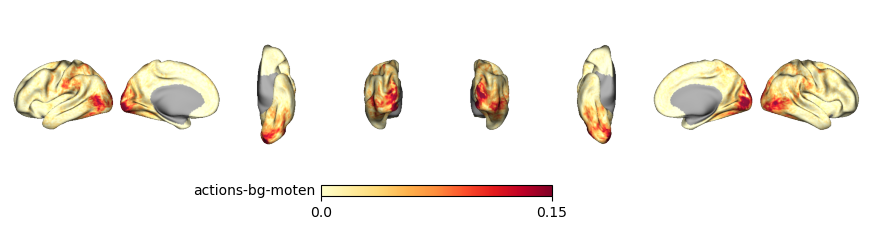

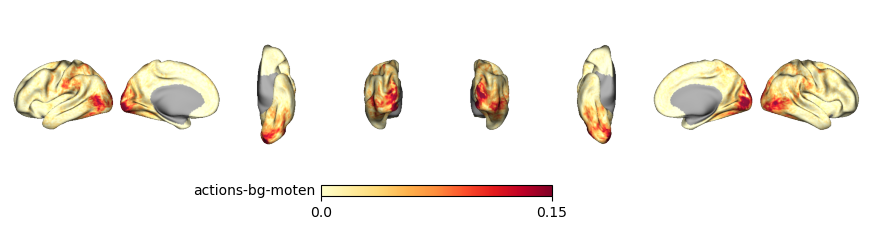

In [40]:
alignment = 'ha_common'
r_type = 'r'

#   f"{output_dir}/variance-{r_type}_{features}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
bgLfname = f"{output_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-lh_ttest.gii"
bgRfname = f"{output_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-rh_ttest.gii"
fsaverage_to_fslr_and_plot(bgLfname, bgRfname, features, cmap='YlOrRd', min=0, max=.15)

## cluster threshold full model results

In [41]:
from subprocess import call
# parameteres
hemis = ['lh', 'rh']
# features = ['bg', 'agents', 'actions', 'moten']
clustersize = 100
hemi_dict = {'lh': 'L', 'rh': 'R'}
fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
data_dir = f'/Volumes/life-encoding/results/himalaya/glove/variancepart'
r_type = 'r'
# thresholding via workbench
for hemi in hemis:
    for feature in nested_list:
        fsaverage_template = f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_inflated.surf.gii"
        himalaya = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
        outputfname = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
        return_code = call(f"wb_command -metric-find-clusters {fsaverage_template} {himalaya} 0 {clustersize} {outputfname}", shell=True)
        
print(f"Return: {return_code}")

Return: 0


## check cluster thresholded maps

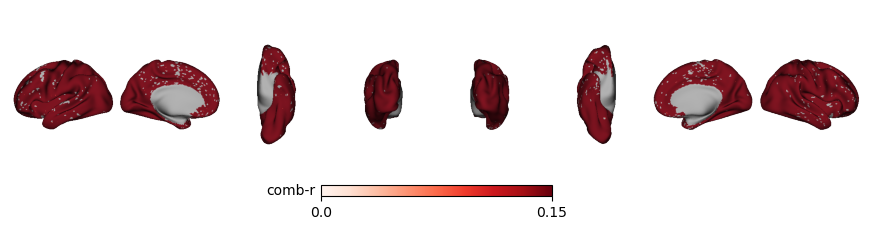

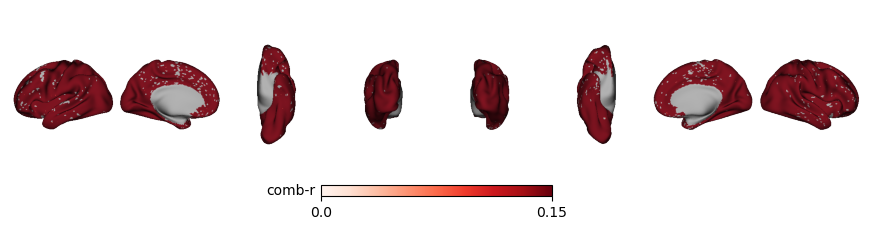

In [42]:
clusterthresL = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-lh_ttest_cluster-{clustersize}.gii"
clusterthresR = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-rh_ttest_cluster-{clustersize}.gii"
fsaverage_to_fslr_and_plot(clusterthresL, clusterthresR, f'{feature}-r', cmap = 'Reds', min=0, max=.15)

## apply full model mask to nested model maps

In [45]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

hemis = ['lh', 'rh']
hemi_dict = {'lh': 'L', 'rh': 'R'}
features = ['bg', 'agents', 'actions', 'moten']
# clustersize = 50

fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
data_dir = '/Volumes/life-encoding/results/himalaya/glove/ha_common_pca-40/stats'

# thresholding via workbench
for hemi in hemis:
    # for feature in features:
    clustermask_fname = f"{data_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
    clustL = nib.load(clustermask_fname).agg_data() > 0
    himalaya_fname = f"{data_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
    himalaya = nib.load(himalaya_fname).agg_data()
    maskeddata = clustL * himalaya
    write_gifti_v2(maskeddata.astype(np.float32), 
        output_fn=f"{data_dir}/{feature}-r_pca-40_align-{alignment}_hemi-{hemi}_ttest_thres-cluster{clustersize}.gii",
        template_fn=f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_pial.surf.gii")

FileNotFoundError: No such file or no access: '/Volumes/life-encoding/results/himalaya/glove/ha_common_pca-40/stats/comb-r_pca-40_align-ha_common_hemi-lh_ttest_cluster-100.gii'